In [9]:
#código para o desafio do bootcamp de TPD

1) Primeiro passo - Seção Spark

In [10]:
from pyspark.sql import SparkSession #importa a biblioteca que cria a seção do spark

In [11]:
#inicia a seção para a utilização do spark
spark = SparkSession.builder.appName("desafio_tpd").getOrCreate() #cria a seção caso não exista ou obtém a já criada

In [12]:
%fs ls /FileStore/tables    

UsageError: Line magic function `%fs` not found.


In [13]:
diretorioDatasetDiabets="Mall_Customers.csv"  #diretório que contém o arquivo a ser utilizado

In [14]:
data = spark.read.format("csv").options(header="true", inferschema="true").load(diretorioDatasetDiabets)  #realiza a leitura do dataset

In [15]:
data.show(5,False)  #mostrando as 5 primeiras instâncias do dataset

+----------+------+---+------------------+----------------------+
|CustomerID|Genre |Age|Annual Income (k$)|Spending Score (1-100)|
+----------+------+---+------------------+----------------------+
|1         |Male  |19 |15                |39                    |
|2         |Male  |21 |15                |81                    |
|3         |Female|20 |16                |6                     |
|4         |Female|23 |16                |77                    |
|5         |Female|31 |17                |40                    |
+----------+------+---+------------------+----------------------+
only showing top 5 rows



In [16]:
data.columns #mostra as colunas do dataset

['CustomerID', 'Genre', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']

In [17]:
data.printSchema()  #mostra o esquema inferido pelas variáveis

root
 |-- CustomerID: integer (nullable = true)
 |-- Genre: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Annual Income (k$): integer (nullable = true)
 |-- Spending Score (1-100): integer (nullable = true)



In [18]:
data.count()  #conta a quantidade de registros

200

In [19]:
#verificando a existência ou não de valores nulos
from pyspark.sql.functions import isnan, when, count, col

data.select([count(when(isnan(c), c)).alias(c) for c in data.columns]).show()

+----------+-----+---+------------------+----------------------+
|CustomerID|Genre|Age|Annual Income (k$)|Spending Score (1-100)|
+----------+-----+---+------------------+----------------------+
|         0|    0|  0|                 0|                     0|
+----------+-----+---+------------------+----------------------+



In [20]:
data.describe().show() #mostrando as estatísticas do dataset

+-------+------------------+------+-----------------+------------------+----------------------+
|summary|        CustomerID| Genre|              Age|Annual Income (k$)|Spending Score (1-100)|
+-------+------------------+------+-----------------+------------------+----------------------+
|  count|               200|   200|              200|               200|                   200|
|   mean|             100.5|  null|            38.85|             60.56|                  50.2|
| stddev|57.879184513951124|  null|13.96900733155888| 26.26472116527124|    25.823521668370173|
|    min|                 1|Female|               18|                15|                     1|
|    max|               200|  Male|               70|               137|                    99|
+-------+------------------+------+-----------------+------------------+----------------------+



Verificando se existem outliers (anomalias) nos dados. Para isso, será utilizado o boxplot.

In [21]:
#selecionando apenas algumas colunas
data_outliers=data.select([c for c in data.columns if c in ['Age','Annual Income (k$)','Spending Score (1-100)']])
data_outliers.show()

+---+------------------+----------------------+
|Age|Annual Income (k$)|Spending Score (1-100)|
+---+------------------+----------------------+
| 19|                15|                    39|
| 21|                15|                    81|
| 20|                16|                     6|
| 23|                16|                    77|
| 31|                17|                    40|
| 22|                17|                    76|
| 35|                18|                     6|
| 23|                18|                    94|
| 64|                19|                     3|
| 30|                19|                    72|
| 67|                19|                    14|
| 35|                19|                    99|
| 58|                20|                    15|
| 24|                20|                    77|
| 37|                20|                    13|
| 22|                20|                    79|
| 35|                21|                    35|
| 20|                21|                

In [49]:
#boxplot
display(data_outliers)

AttributeError: 'DataFrame' object has no attribute 'data'

In [23]:
#histograma
display(data_outliers)

DataFrame[Age: int, Annual Income (k$): int, Spending Score (1-100): int]

Conhecendo o dataset

In [24]:
display(data.select(["Genre","Annual Income (k$)"]))

DataFrame[Genre: string, Annual Income (k$): int]

In [25]:
#distribuição dos consumidores pela idade
display(data.select(["Age"]))

DataFrame[Age: int]

In [26]:
#encontrando a distribuição da idade x sexo
display(data.select(["Age","Genre"]))

DataFrame[Age: int, Genre: string]

In [27]:
#encontrando a distribuição da idade x sexo
display(data.select(["Age","Genre"]))

DataFrame[Age: int, Genre: string]

A variável "Spending Score (1-100)" ou pontuação de consumo, corresponde à nota atribuída pelo shopping aos consumidores. Quanto mais próxima de 100 indica que o consumidor é mais "lucrativo" para o shopping.

In [28]:
#encontrando as notas atribuidas por gênero 
display(data.select(["Spending Score (1-100)","Genre"]))

DataFrame[Spending Score (1-100): int, Genre: string]

Analisando a correlação entre Idade e Nota Atribuída

In [29]:
#Analisando as correlações
from pyspark.mllib.stat import Statistics

In [30]:
rdd_1=data.select("Spending Score (1-100)").rdd.flatMap(lambda x:x)  #utilizada para transforma das colunas do dataframe em colunas para serem empregadas na análise de correlaçoes
rdd_2=data.select("Age").rdd.flatMap(lambda x:x)

In [31]:
Statistics.corr(rdd_1,rdd_2,method="pearson")  #definindo a coeficiente de correlação de pearson 

-0.32722684603909014

In [32]:
data.stat.corr("Age","Annual Income (k$)",method="pearson")

-0.01239804273606026

Analisando a correlação por gênero

In [33]:
#Selecionando os homens
homens=data[data.Genre=='Male']
homens.show()

+----------+-----+---+------------------+----------------------+
|CustomerID|Genre|Age|Annual Income (k$)|Spending Score (1-100)|
+----------+-----+---+------------------+----------------------+
|         1| Male| 19|                15|                    39|
|         2| Male| 21|                15|                    81|
|         9| Male| 64|                19|                     3|
|        11| Male| 67|                19|                    14|
|        15| Male| 37|                20|                    13|
|        16| Male| 22|                20|                    79|
|        18| Male| 20|                21|                    66|
|        19| Male| 52|                23|                    29|
|        21| Male| 35|                24|                    35|
|        22| Male| 25|                24|                    73|
|        24| Male| 31|                25|                    73|
|        26| Male| 29|                28|                    82|
|        28| Male| 35|   

In [34]:
#selecionando mulheres
mulheres=data[data.Genre=='Female']
mulheres.show()

+----------+------+---+------------------+----------------------+
|CustomerID| Genre|Age|Annual Income (k$)|Spending Score (1-100)|
+----------+------+---+------------------+----------------------+
|         3|Female| 20|                16|                     6|
|         4|Female| 23|                16|                    77|
|         5|Female| 31|                17|                    40|
|         6|Female| 22|                17|                    76|
|         7|Female| 35|                18|                     6|
|         8|Female| 23|                18|                    94|
|        10|Female| 30|                19|                    72|
|        12|Female| 35|                19|                    99|
|        13|Female| 58|                20|                    15|
|        14|Female| 24|                20|                    77|
|        17|Female| 35|                21|                    35|
|        20|Female| 35|                23|                    98|
|        2

In [35]:
#correlação entre Idade e o Salário Anual - Homens
homens.stat.corr("Age","Spending Score (1-100)",method="pearson")

-0.27962764627493125

In [36]:
#correlação entre Idade e o Salário Anual - Homens
mulheres.stat.corr("Age","Spending Score (1-100)",method="pearson")

-0.3754385837780473

Aplicando o Kmeans

In [37]:
from pyspark.ml.evaluation import ClusteringEvaluator  #biblioteca utilizada para a avaliação em cada um dos clusters
from pyspark.ml.clustering import KMeans #biblioteca utilizada para a criação do modelo de clusterização utilizando o K-means

In [38]:
from pyspark.ml.feature import VectorAssembler  #transformando os dados em vetores de características

vecAssembler = VectorAssembler(inputCols=["Spending Score (1-100)","Annual Income (k$)"], outputCol="features") #utilizada para transformar os dados em um vetor (define o objeto)
new_df = vecAssembler.transform(data) #Aplico a transformação
new_df.show()

+----------+------+---+------------------+----------------------+-----------+
|CustomerID| Genre|Age|Annual Income (k$)|Spending Score (1-100)|   features|
+----------+------+---+------------------+----------------------+-----------+
|         1|  Male| 19|                15|                    39|[39.0,15.0]|
|         2|  Male| 21|                15|                    81|[81.0,15.0]|
|         3|Female| 20|                16|                     6| [6.0,16.0]|
|         4|Female| 23|                16|                    77|[77.0,16.0]|
|         5|Female| 31|                17|                    40|[40.0,17.0]|
|         6|Female| 22|                17|                    76|[76.0,17.0]|
|         7|Female| 35|                18|                     6| [6.0,18.0]|
|         8|Female| 23|                18|                    94|[94.0,18.0]|
|         9|  Male| 64|                19|                     3| [3.0,19.0]|
|        10|Female| 30|                19|                    72

In [50]:
#aplica o processo de clusterização
kmeans = KMeans(k=3, seed=1)  # declara o objeto - 3 clusters 
model = kmeans.fit(new_df.select('features')) #aplica o treinamento

In [51]:
#cria o dataset com a indicação sobre qual cluster cada conjunto de dados foi adicionado
df_final = model.transform(new_df)
df_final.show() 

+----------+------+---+------------------+----------------------+-----------+----------+
|CustomerID| Genre|Age|Annual Income (k$)|Spending Score (1-100)|   features|prediction|
+----------+------+---+------------------+----------------------+-----------+----------+
|         1|  Male| 19|                15|                    39|[39.0,15.0]|         2|
|         2|  Male| 21|                15|                    81|[81.0,15.0]|         2|
|         3|Female| 20|                16|                     6| [6.0,16.0]|         2|
|         4|Female| 23|                16|                    77|[77.0,16.0]|         2|
|         5|Female| 31|                17|                    40|[40.0,17.0]|         2|
|         6|Female| 22|                17|                    76|[76.0,17.0]|         2|
|         7|Female| 35|                18|                     6| [6.0,18.0]|         2|
|         8|Female| 23|                18|                    94|[94.0,18.0]|         2|
|         9|  Male| 6

In [52]:
data.describe().show()

+-------+------------------+------+-----------------+------------------+----------------------+
|summary|        CustomerID| Genre|              Age|Annual Income (k$)|Spending Score (1-100)|
+-------+------------------+------+-----------------+------------------+----------------------+
|  count|               200|   200|              200|               200|                   200|
|   mean|             100.5|  null|            38.85|             60.56|                  50.2|
| stddev|57.879184513951124|  null|13.96900733155888| 26.26472116527124|    25.823521668370173|
|    min|                 1|Female|               18|                15|                     1|
|    max|               200|  Male|               70|               137|                    99|
+-------+------------------+------+-----------------+------------------+----------------------+



In [53]:
df_final.groupby('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   39|
|         2|  123|
|         0|   38|
+----------+-----+



In [54]:
#transformando os dados utilizando o pandas 
data_pandas = df_final.toPandas().set_index('CustomerID')
data_pandas.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100),features,prediction
CustomerID,,,,,,
1,Male,19,15,39,"[39.0, 15.0]",2
2,Male,21,15,81,"[81.0, 15.0]",2
3,Female,20,16,6,"[6.0, 16.0]",2
4,Female,23,16,77,"[77.0, 16.0]",2
5,Female,31,17,40,"[40.0, 17.0]",2


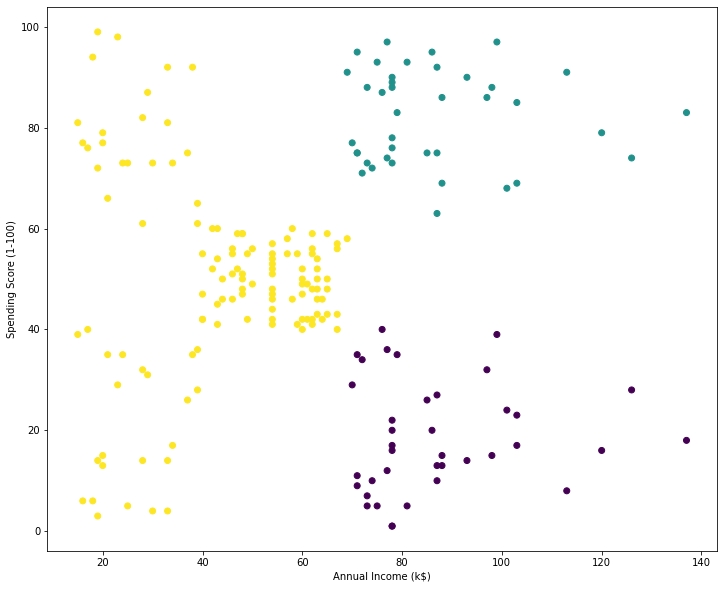

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
plt.scatter(data_pandas['Annual Income (k$)'], data_pandas['Spending Score (1-100)'], c=data_pandas.prediction)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()